In [13]:
#import libraries

import os
from pathlib import Path
import json
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px
import io


# pipeline.py

In [6]:
# ==============================
# 0. CONFIG
# ==============================

# Where to save local CSVs
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

# Remote sources
HEALTH_URL = "https://storage.googleapis.com/covid19-open-data/v3/health.csv"
WORLD_BANK_BASE = "https://api.worldbank.org/v2"
TARGET_YEAR = "2022"

# World Bank indicators (you can enrich later with the others if you want)
INDICATORS = {
    "NY.GDP.MKTP.CD": "GDP (current US$)",
    "NY.GDP.PCAP.CD": "GDP per capita (current US$)",
    "SL.UEM.TOTL.ZS": "Unemployment rate (% of labor force)",
    "NY.GDP.MKTP.KD": "GDP (constant 2015 US$)",
}

GDP_PER_CAPITA_INDICATOR = "NY.GDP.PCAP.CD"



In [7]:
# ==============================
# 1. RETRIEVAL
# ==============================

def fetch_health_data():
    """Download base health.csv and return as DataFrame named `health`."""
    print(f"Downloading health data from: {HEALTH_URL}")
    health = pd.read_csv(HEALTH_URL)

    print("✓ Raw health data loaded from remote health.csv")
    print(f"  Shape: {health.shape[0]:,} rows × {health.shape[1]} columns")
    print(f"  Columns (first 10): {list(health.columns)[:10]} ...\n")

    # Save locally
    health.to_csv(DATA_DIR / "health.csv", index=False)
    print(f"✓ Saved health.csv to {DATA_DIR.resolve()}\n")

    return health


def fetch_worldbank_gdp_per_capita(countries):
    """
    Fetch REAL GDP per capita data from World Bank API
    for a list of ISO country codes.
    Returns DataFrame named `economic_data`.
    """
    print("Endpoint: https://api.worldbank.org/v2/")
    print("Attempting to fetch REAL data from World Bank API...\n")

    economic_data_list = []

    for country_code in countries:
        try:
            gdp_url = (
                f"{WORLD_BANK_BASE}/country/{country_code}/indicators/"
                f"{GDP_PER_CAPITA_INDICATOR}?format=json&date={TARGET_YEAR}"
            )

            print(f"  {country_code}: Connecting to API... ", end="")
            gdp_response = requests.get(gdp_url, timeout=60)

            if gdp_response.status_code == 200:
                gdp_data = gdp_response.json()

                # Extract REAL values from API response
                if gdp_data and len(gdp_data) > 1 and gdp_data[1]:
                    data_point = gdp_data[1][0]
                    gdp_value = data_point.get("value")

                    if gdp_value is not None:
                        economic_data_list.append({
                            "location_key": country_code,
                            "gdp_per_capita_usd": float(gdp_value),
                            "data_year": data_point.get("date"),
                            "source": "World Bank API (REAL DATA)",
                        })
                        print(f"✓ Got REAL data: ${float(gdp_value):,.0f}")
                    else:
                        print("✗ No value in response")
                else:
                    print("✗ Empty response")
            else:
                print(f"✗ Status {gdp_response.status_code}")

        except requests.exceptions.Timeout:
            print("⚠ Timeout")
        except Exception as e:
            print(f"✗ Error ({str(e)[:40]})")

    # Create DataFrame from fetched data
    if economic_data_list:
        economic_data = pd.DataFrame(economic_data_list)
        print(
            f"\nSuccessfully retrieved {len(economic_data)} countries "
            f"with REAL World Bank data!"
        )
        print("\n   Sample:")
        print(economic_data[["location_key", "gdp_per_capita_usd", "data_year"]].head())
    else:
        print("\n⚠ No REAL data retrieved from API")
        print("   Creating empty DataFrame...")
        # Fallback placeholder if API fails
        economic_data = pd.DataFrame({
            "location_key": countries[:5],
            "gdp_per_capita_usd": [np.nan] * 5,
            "source": "World Bank API (Attempted - No Data Retrieved)",
        })

    # Save locally
    economic_data.to_csv(DATA_DIR / "economic_data.csv", index=False)
    print(f"\n✓ Saved economic_data.csv to {DATA_DIR.resolve()}\n")

    return economic_data



In [8]:
# ==============================
# 2. MERGE → df_clean
# ==============================

def build_df_clean(health, economic_data):
    """
    Merge health + economic_data on `location_key`
    to create df_clean (same name you used before).
    """
    df_clean = health.merge(economic_data, how="left", on="location_key")
    print(
        f"✓ Combined dataset df_clean: "
        f"{df_clean.shape[0]:,} rows × {df_clean.shape[1]} columns\n"
    )

    # Save locally
    df_clean.to_csv(DATA_DIR / "df_clean.csv", index=False)
    print(f"✓ Saved df_clean.csv to {DATA_DIR.resolve()}\n")

    return df_clean



In [9]:
# ==============================
# 3. CLEANING & ENRICHMENT
# ==============================

def clean_and_enrich(df_clean):
    """
    Put the *key* cleaning + feature-engineering steps from enrichment.ipynb here.

    For now I’m giving you a light, safe version that you can expand
    by copy-pasting your existing enrichment code into this function
    (but using df_clean instead of re-reading from Drive).
    """
    df = df_clean.copy()

    # make sure numeric cols are numeric
    numeric_cols = [
        c for c in df.columns
        if df[c].dtype == "object" and c not in ["location_key", "country_name"]
    ]
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors="ignore")

    # derive a simple feature
    if {"new_confirmed", "population"} <= set(df.columns):
        df["cases_per_100k"] = (
            df["new_confirmed"] / df["population"] * 1e5
        )


    df_enriched = df

    # Save enriched version if you want
    df_enriched.to_csv(DATA_DIR / "df_enriched.csv", index=False)
    print(f"✓ Saved df_enriched.csv to {DATA_DIR.resolve()}\n")

    return df_enriched



In [10]:
# ==============================
# 4. BASIC ANALYSIS / CHECKS
# ==============================

def run_basic_analysis(df_enriched):
    """
    Minimal analysis stub – you can copy plots / groupbys from analysis.ipynb here.
    """
    print("=== BASIC SUMMARY ===")
    print(df_enriched.describe(include="all").T.head())

    # Example: top 10 countries by GDP per capita (where you have data)
    if "gdp_per_capita_usd" in df_enriched.columns:
        top_gdp = (
            df_enriched
            .dropna(subset=["gdp_per_capita_usd"])
            .sort_values("gdp_per_capita_usd", ascending=False)
            .head(10)[["location_key", "gdp_per_capita_usd"]]
        )
        print("\nTop 10 countries by GDP per capita:")
        print(top_gdp)



In [14]:
# ==============================
# 5. MAIN PIPELINE
# ==============================

def main():
    # 1) Health retrieval
    health = fetch_health_data()

    # Extract country codes for API enrichment (same logic as before)
    countries = (
        health.loc[~health["location_key"].str.contains("_", na=False), "location_key"]
        .dropna()
        .unique()
    )
    print(f"✓ Extracted {len(countries)} country codes for API enrichment")
    print(f"  Sample countries: {', '.join(countries[:10])}\n")

    # 2) Economic retrieval from World Bank
    economic_data = fetch_worldbank_gdp_per_capita(countries)

    # 3) Merge into df_clean
    df_clean = build_df_clean(health, economic_data)

    # 4) Cleaning + enrichment
    df_enriched = clean_and_enrich(df_clean)

    # 5) Simple analysis
    run_basic_analysis(df_enriched)

    print("\n=== PIPELINE COMPLETE ===")
    print("Local files created in:", DATA_DIR.resolve())


if __name__ == "__main__":
    main()


✓ Raw health data loaded from remote health.csv
  Shape: 3,504 rows × 14 columns
  Columns (first 10): ['location_key', 'life_expectancy', 'smoking_prevalence', 'diabetes_prevalence', 'infant_mortality_rate', 'adult_male_mortality_rate', 'adult_female_mortality_rate', 'pollution_mortality_rate', 'comorbidity_mortality_rate', 'hospital_beds_per_1000'] ...

✓ Saved health.csv to /Users/raynerjlee/Downloads/MA705/Project Health/data

✓ Extracted 209 country codes for API enrichment
  Sample countries: AD, AE, AF, AG, AL, AM, AO, AR, AT, AU

Endpoint: https://api.worldbank.org/v2/
Attempting to fetch REAL data from World Bank API...

  AD: Connecting to API... ✓ Got REAL data: $42,414
  AE: Connecting to API... ✓ Got REAL data: $49,899
  AF: Connecting to API... ✓ Got REAL data: $357
  AG: Connecting to API... ⚠ Timeout
  AL: Connecting to API... ✓ Got REAL data: $6,846
  AM: Connecting to API... ✓ Got REAL data: $6,572
  AO: Connecting to API... ⚠ Timeout
  AR: Connecting to API... ✓ Got 

Loaded df_enriched from data/df_enriched.csv
Life Expectancy Statistics (in years):
  Mean:      77.82
  Median:    77.77
  Std Dev:   7.60
  Min:       52.80
  25th %ile: 75.85
  75th %ile: 79.75
  Max:       401.31

Infant Mortality Rate (per 1000 births):
  Mean:   21.38
  Median: 14.00
  Min:    1.40
  Max:    84.50

Health Expenditure (USD per capita):
  Mean:      $1081
  Median:    $336
  Min:       $19
  Max:       $10246
  90th:      $3898



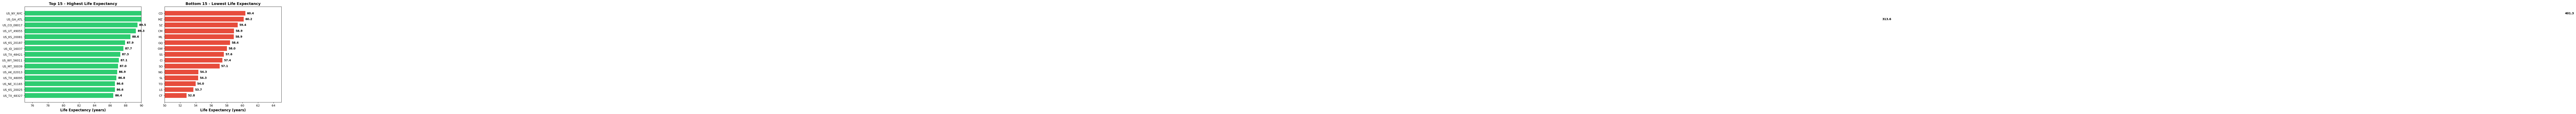

They have a 348.5 year global gap



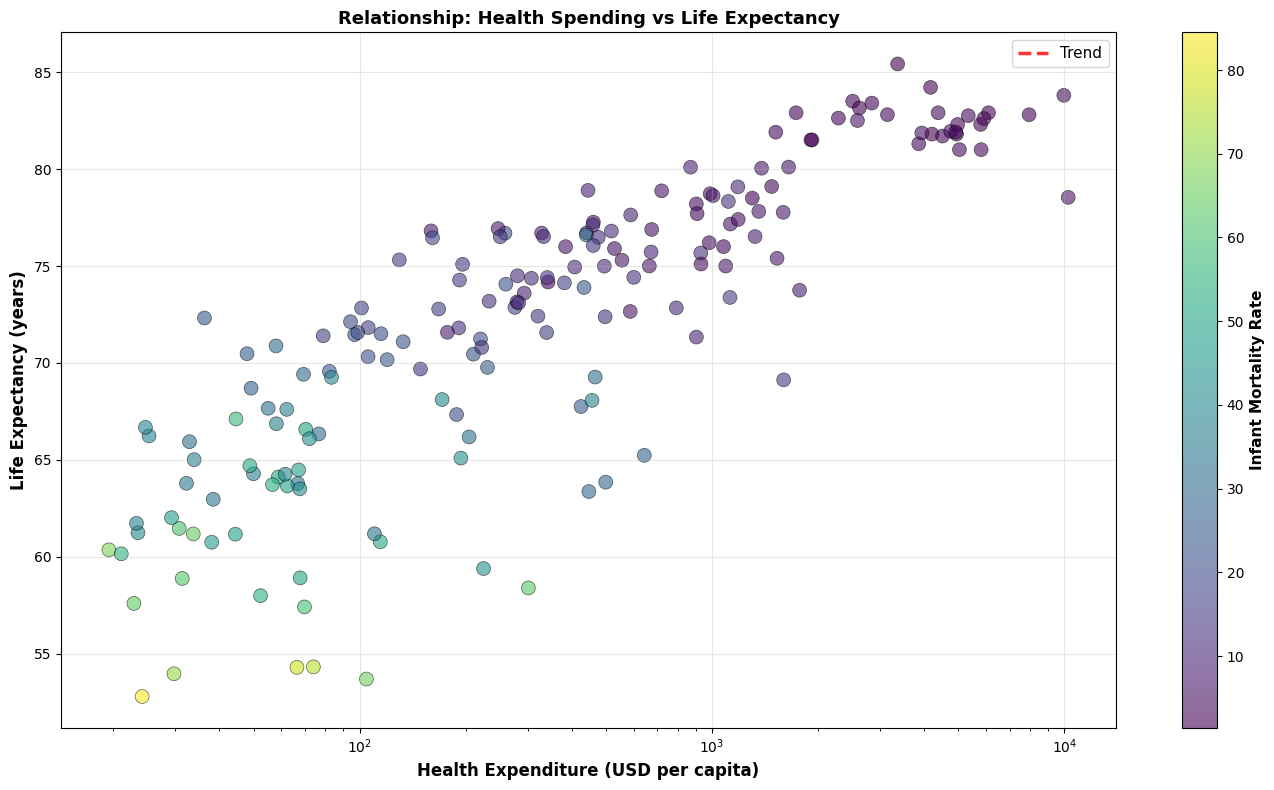

Positive correlation between spending and life expectancy = 0.6012



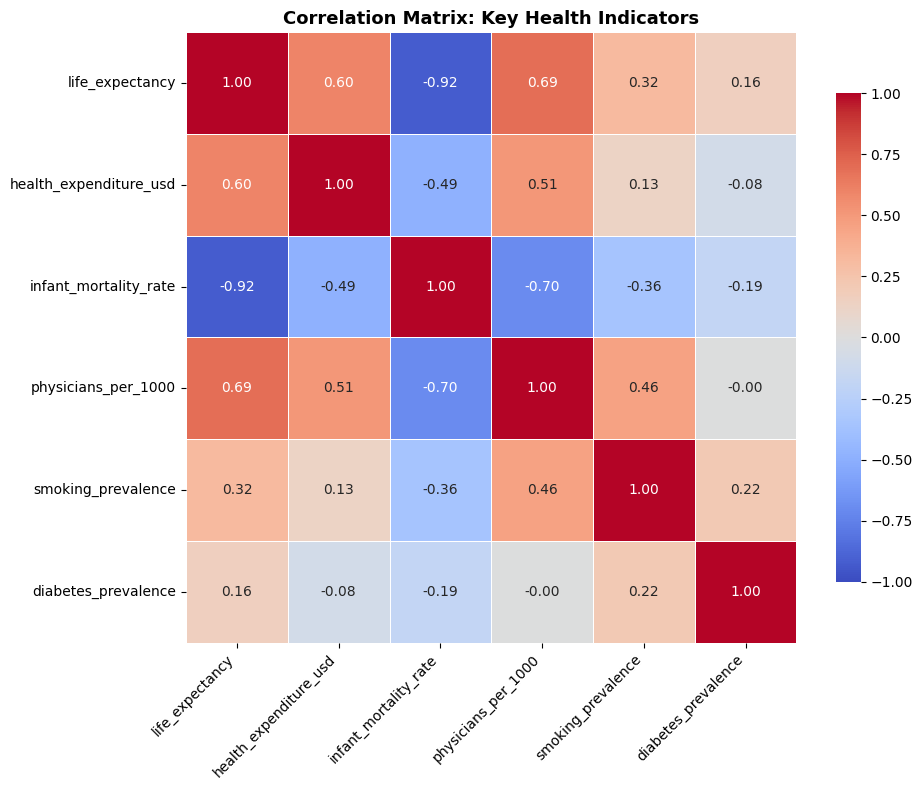

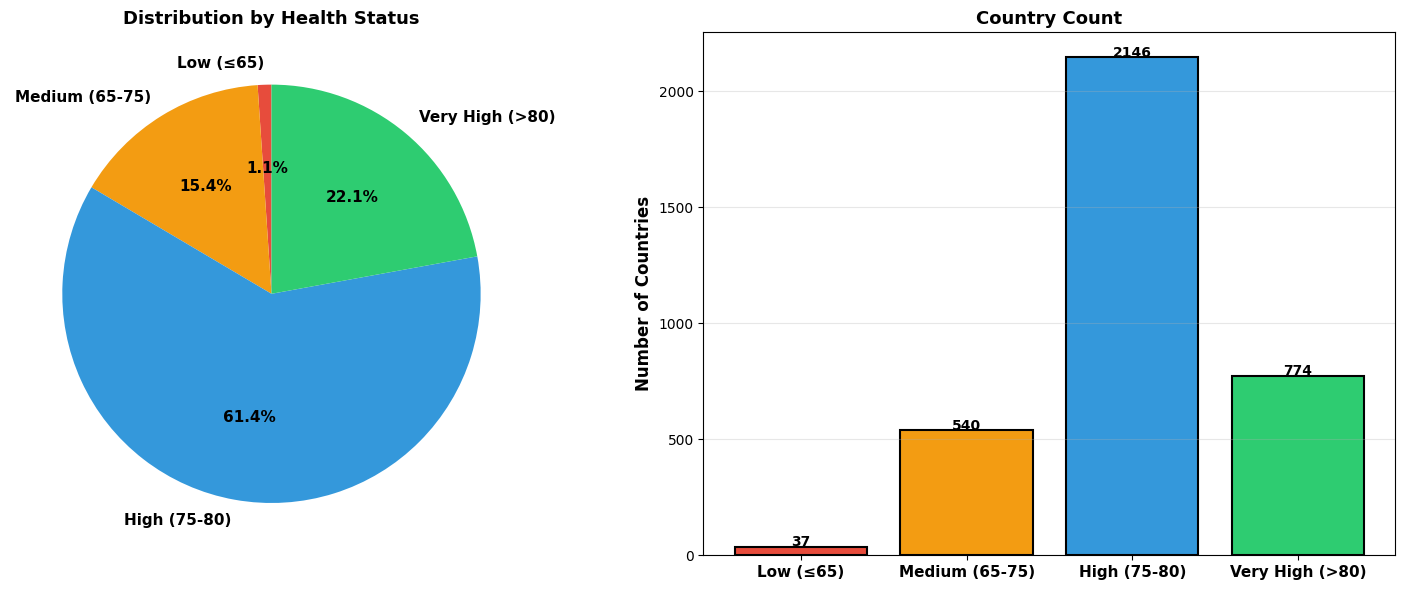

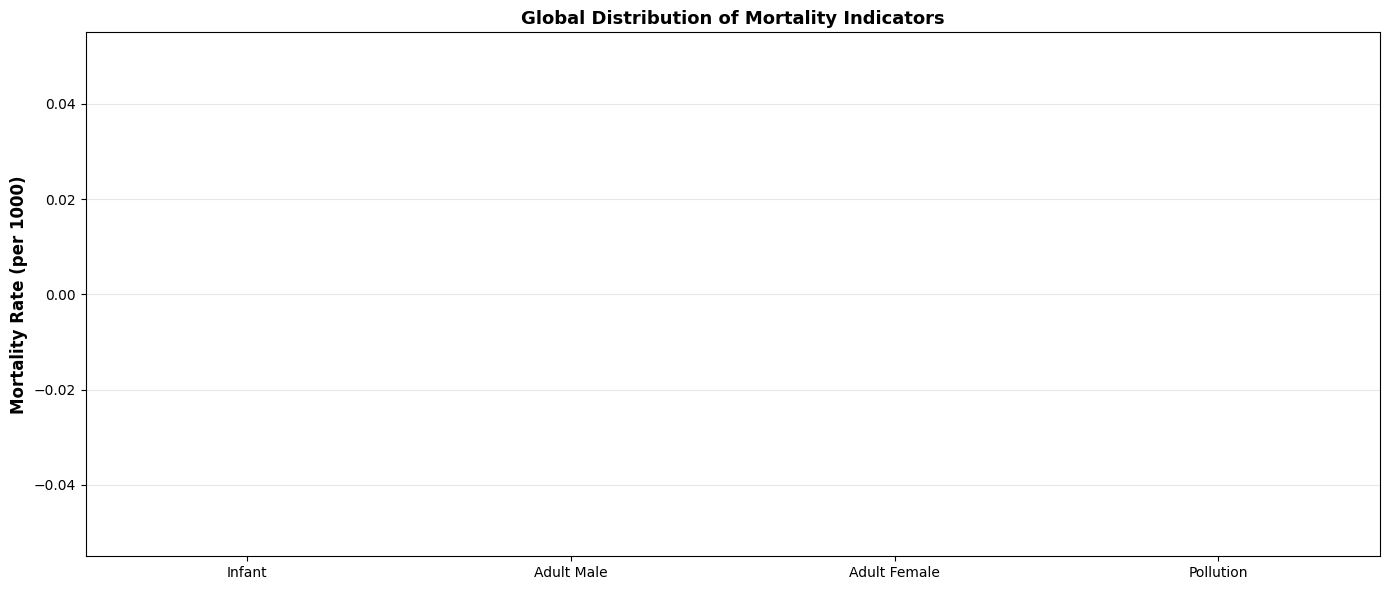

In [17]:
# ==============================
# 4. ANALYSIS & PLOTS (no sklearn)
# ==============================

# First ensure df_enriched is available

if "df_enriched" not in globals():
    # Adjust path if your CSV is elsewhere
    df_enriched = pd.read_csv("data/df_enriched.csv")
    print("Loaded df_enriched from data/df_enriched.csv")
else:
    print("Using existing df_enriched from memory")

# Make sure required columns exist or handle missing:
required_cols = [
    "life_expectancy",
    "infant_mortality_rate",
    "adult_male_mortality_rate",
    "adult_female_mortality_rate",
    "pollution_mortality_rate",
    "health_expenditure_usd",
    "physicians_per_1000",
    "nurses_per_1000",
    "smoking_prevalence",
    "diabetes_prevalence",
    "location_key"
]

missing_cols = [c for c in required_cols if c not in df_enriched.columns]
if missing_cols:
    print("⚠ WARNING: The following columns are missing from df_enriched:")
    print("   ", missing_cols)
    print("   The analysis below is skipped until these columns are created/renamed.\n")
else:
    # --- Meaningful Summary Statistics ---

    print("Life Expectancy Statistics (in years):")
    print(f"  Mean:      {df_enriched['life_expectancy'].mean():.2f}")
    print(f"  Median:    {df_enriched['life_expectancy'].median():.2f}")
    print(f"  Std Dev:   {df_enriched['life_expectancy'].std():.2f}")
    print(f"  Min:       {df_enriched['life_expectancy'].min():.2f}")
    print(f"  25th %ile: {df_enriched['life_expectancy'].quantile(0.25):.2f}")
    print(f"  75th %ile: {df_enriched['life_expectancy'].quantile(0.75):.2f}")
    print(f"  Max:       {df_enriched['life_expectancy'].max():.2f}\n")

    print("Infant Mortality Rate (per 1000 births):")
    print(f"  Mean:   {df_enriched['infant_mortality_rate'].mean():.2f}")
    print(f"  Median: {df_enriched['infant_mortality_rate'].median():.2f}")
    print(f"  Min:    {df_enriched['infant_mortality_rate'].min():.2f}")
    print(f"  Max:    {df_enriched['infant_mortality_rate'].max():.2f}\n")

    print("Health Expenditure (USD per capita):")
    print(f"  Mean:      ${df_enriched['health_expenditure_usd'].mean():.0f}")
    print(f"  Median:    ${df_enriched['health_expenditure_usd'].median():.0f}")
    print(f"  Min:       ${df_enriched['health_expenditure_usd'].min():.0f}")
    print(f"  Max:       ${df_enriched['health_expenditure_usd'].max():.0f}")
    print(f"  90th:      ${df_enriched['health_expenditure_usd'].quantile(0.9):.0f}\n")

    # --- Life Expectancy Distribution ---

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Top 15
    top_15 = (
        df_enriched
        .nlargest(15, "life_expectancy")[["location_key", "life_expectancy"]]
        .sort_values("life_expectancy")
    )
    ax1.barh(top_15["location_key"], top_15["life_expectancy"], color="#2ecc71")
    ax1.set_xlabel("Life Expectancy (years)", fontsize=12, fontweight="bold")
    ax1.set_title("Top 15 - Highest Life Expectancy", fontsize=13, fontweight="bold")
    ax1.set_xlim(75, 90)
    for i, v in enumerate(top_15["life_expectancy"]):
        ax1.text(v + 0.2, i, f"{v:.1f}", va="center", fontweight="bold")

    # Bottom 15
    bottom_15 = (
        df_enriched
        .nsmallest(15, "life_expectancy")[["location_key", "life_expectancy"]]
        .sort_values("life_expectancy")
    )
    ax2.barh(bottom_15["location_key"], bottom_15["life_expectancy"], color="#e74c3c")
    ax2.set_xlabel("Life Expectancy (years)", fontsize=12, fontweight="bold")
    ax2.set_title("Bottom 15 - Lowest Life Expectancy", fontsize=13, fontweight="bold")
    ax2.set_xlim(50, 65)
    for i, v in enumerate(bottom_15["life_expectancy"]):
        ax2.text(v + 0.2, i, f"{v:.1f}", va="center", fontweight="bold")

    plt.tight_layout()
    plt.show()

    print(
        f"They have a "
        f"{top_15['life_expectancy'].iloc[-1] - bottom_15['life_expectancy'].iloc[0]:.1f} "
        f"year global gap\n"
    )

    # --- Health Spending vs Life Expectancy ---

    fig, ax = plt.subplots(figsize=(14, 8))

    scatter = ax.scatter(
        df_enriched["health_expenditure_usd"],
        df_enriched["life_expectancy"],
        s=100,
        alpha=0.6,
        c=df_enriched["infant_mortality_rate"],
        cmap="viridis",
        edgecolors="black",
        linewidth=0.5,
    )

    # Trend line (simple linear fit)
    x_vals = df_enriched["health_expenditure_usd"].fillna(0)
    y_vals = df_enriched["life_expectancy"]
    z = np.polyfit(x_vals, y_vals, 1)
    p = np.poly1d(z)
    x_trend = np.linspace(0, x_vals.max(), 100)
    ax.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2.5, label="Trend")

    ax.set_xlabel("Health Expenditure (USD per capita)", fontsize=12, fontweight="bold")
    ax.set_ylabel("Life Expectancy (years)", fontsize=12, fontweight="bold")
    ax.set_title("Relationship: Health Spending vs Life Expectancy", fontsize=13, fontweight="bold")
    ax.set_xscale("log")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label("Infant Mortality Rate", fontsize=11, fontweight="bold")
    plt.tight_layout()
    plt.show()

    corr = df_enriched["health_expenditure_usd"].corr(df_enriched["life_expectancy"])
    print(f"Positive correlation between spending and life expectancy = {corr:.4f}\n")

    # --- Correlation Heatmap ---

    corr_vars = [
        "life_expectancy", "health_expenditure_usd", "infant_mortality_rate",
        "physicians_per_1000", "smoking_prevalence", "diabetes_prevalence"
    ]

    corr_matrix = df_enriched[corr_vars].corr()

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0,
        square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
        ax=ax, vmin=-1, vmax=1
    )
    ax.set_title("Correlation Matrix: Key Health Indicators", fontsize=13, fontweight="bold")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # --- Country Health Status Distribution ---

    df_enriched["health_status"] = pd.cut(
        df_enriched["life_expectancy"],
        bins=[0, 65, 75, 80, 100],
        labels=["Low (≤65)", "Medium (65-75)", "High (75-80)", "Very High (>80)"],
    )

    health_counts = df_enriched["health_status"].value_counts().sort_index()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    colors = ["#e74c3c", "#f39c12", "#3498db", "#2ecc71"]
    ax1.pie(
        health_counts, labels=health_counts.index, autopct="%1.1f%%",
        colors=colors, startangle=90, textprops={"fontsize": 11, "fontweight": "bold"}
    )
    ax1.set_title("Distribution by Health Status", fontsize=13, fontweight="bold")

    ax2.bar(range(len(health_counts)), health_counts.values,
            color=colors, edgecolor="black", linewidth=1.5)
    ax2.set_xticks(range(len(health_counts)))
    ax2.set_xticklabels(health_counts.index, fontsize=11, fontweight="bold")
    ax2.set_ylabel("Number of Countries", fontsize=12, fontweight="bold")
    ax2.set_title("Country Count", fontsize=13, fontweight="bold")
    ax2.grid(axis="y", alpha=0.3)
    for i, v in enumerate(health_counts.values):
        ax2.text(i, v + 1, str(v), ha="center", fontweight="bold")

    plt.tight_layout()
    plt.show()

    # --- Mortality Indicators Comparison ---

    fig, ax = plt.subplots(figsize=(14, 6))

    mortality_data = [
        df_enriched["infant_mortality_rate"],
        df_enriched["adult_male_mortality_rate"],
        df_enriched["adult_female_mortality_rate"],
        df_enriched["pollution_mortality_rate"],
    ]
    labels = ["Infant", "Adult Male", "Adult Female", "Pollution"]

    ax.boxplot(
        mortality_data,
        labels=labels,
        patch_artist=True,
        medianprops=dict(color="red", linewidth=2),
        boxprops=dict(facecolor="lightblue", alpha=0.7),
        whiskerprops=dict(linewidth=1.5),
        capprops=dict(linewidth=1.5),
    )

    ax.set_ylabel("Mortality Rate (per 1000)", fontsize=12, fontweight="bold")
    ax.set_title("Global Distribution of Mortality Indicators", fontsize=13, fontweight="bold")
    ax.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()
